### Can we predict a market regime from correlation matrix features?


https://gmarti.gitlab.io/qfin/2020/09/04/correlation-matrix-features-market-regimes.html

In [19]:
%matplotlib inline

from multiprocessing import Pool
import tqdm
import numpy as np
import pandas as pd
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import fastcluster
import networkx as nx
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [20]:
def compute_mst_stats(corr):
    dist = (1 - corr) / 2
    G = nx.from_numpy_matrix(dist) 
    mst = nx.minimum_spanning_tree(G)

    features = pd.Series()
    features['mst_avg_shortest'] = nx.average_shortest_path_length(mst)


    closeness_centrality = (pd
                            .Series(list(nx
                                         .closeness_centrality(mst)
                                         .values()))
                            .describe())
    for stat in closeness_centrality.index[1:]:
        features[f'mst_centrality_{stat}'] = closeness_centrality[stat]

    return features

In [30]:
compute_mst_stats(corr_matrices)

mst_avg_shortest       6.660404
mst_centrality_mean    0.155951
mst_centrality_std     0.030770
mst_centrality_min     0.099899
mst_centrality_25%     0.133071
mst_centrality_50%     0.152542
mst_centrality_75%     0.173989
mst_centrality_max     0.240876
dtype: float64

In [21]:
def compute_intravar_clusters(model_corr, Z, nb_clusters=5):
    clustering_inds = hierarchy.fcluster(Z, nb_clusters,
                                         criterion='maxclust')
    clusters = {i: [] for i in range(min(clustering_inds),
                                     max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(i)

    total_var = 0
    for cluster in clusters:
        sub_corr = model_corr[clusters[cluster], :][:, clusters[cluster]]
        sa, sb = np.triu_indices(sub_corr.shape[0], k=1)
        mean_corr = sub_corr[sa, sb].mean()
        cluster_var = sum(
            [(sub_corr[i, j] - mean_corr)**2 for i in range(len(sub_corr))
             for j in range(i + 1, len(sub_corr))])
        total_var += cluster_var
    
    return total_var


In [22]:
def compute_features_from_correl(model_corr):
    n = len(model_corr)
    a, b = np.triu_indices(n, k=1)
  
    features = pd.Series()
    coefficients = model_corr[a, b].flatten()

    coeffs = pd.Series(coefficients)
    coeffs_stats = coeffs.describe()
    for stat in coeffs_stats.index[1:]:
        features[f'coeffs_{stat}'] = coeffs_stats[stat]
    features['coeffs_1%'] = coeffs.quantile(q=0.01)
    features['coeffs_99%'] = coeffs.quantile(q=0.99)
    features['coeffs_10%'] = coeffs.quantile(q=0.1)
    features['coeffs_90%'] = coeffs.quantile(q=0.9)
    features['coeffs_99-90'] = features['coeffs_99%'] - features['coeffs_90%']
    features['coeffs_10-1'] = features['coeffs_10%'] - features['coeffs_1%']


    # eigenvals
    eigenvals, eigenvecs = np.linalg.eig(model_corr)
    permutation = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[permutation]
    eigenvecs = eigenvecs[:, permutation]

    pf_vector = eigenvecs[:, np.argmax(eigenvals)]
    if len(pf_vector[pf_vector < 0]) > len(pf_vector[pf_vector > 0]):
        pf_vector = -pf_vector

    features['varex_eig1'] = float(eigenvals[0] / sum(eigenvals))
    features['varex_eig_top5'] = (float(sum(eigenvals[:5])) /
        float(sum(eigenvals)))
    features['varex_eig_top30'] = (float(sum(eigenvals[:30])) /
        float(sum(eigenvals)))
    features['varex_5-1'] = (features['varex_eig_top5'] -
        features['varex_eig1'])
    features['varex_30-5'] = (features['varex_eig_top30'] -
        features['varex_eig_top5'])
    # Marcenko-Pastur (RMT)
    T, N = 252, n
    MP_cutoff = (1 + np.sqrt(N / T))**2
    # variance explained by eigenvals outside of the MP distribution
    features['varex_eig_MP'] = (
        float(sum([e for e in eigenvals if e > MP_cutoff])) /
        float(sum(eigenvals)))
    
    # determinant
    features['determinant'] = np.prod(eigenvals)
    
    # condition number
    features['condition_number'] = abs(eigenvals[0]) / abs(eigenvals[-1])


    # stats of the first eigenvector entries
    pf_stats = pd.Series(pf_vector).describe()
    for stat in pf_stats.index[1:]:
        features[f'pf_{stat}'] = float(pf_stats[stat])


    # stats on the MST
    features = pd.concat([features, compute_mst_stats(model_corr)],
                         axis=0)

    # stats on the linkage
    dist = np.sqrt(2 * (1 - model_corr))
    for algo in ['ward', 'single', 'complete', 'average']:
        Z = fastcluster.linkage(dist[a, b], method=algo)
        features[f'coph_corr_{algo}'] = cophenet(Z, dist[a, b])[0]
        
    # stats on the clusters
    Z = fastcluster.linkage(dist[a, b], method='ward')
    features['cl_intravar_5'] = compute_intravar_clusters(
        model_corr, Z, nb_clusters=5)
    features['cl_intravar_10'] = compute_intravar_clusters(
        model_corr, Z, nb_clusters=10)
    features['cl_intravar_25'] = compute_intravar_clusters(
        model_corr, Z, nb_clusters=25)
    features['cl_intravar_5-10'] = (
        features['cl_intravar_5'] - features['cl_intravar_10'])
    features['cl_intravar_10-25'] = (
        features['cl_intravar_10'] - features['cl_intravar_25'])

    return features.sort_index()
def compute_dataset_features(mats):
    all_features = []
    for i in range(mats.shape[0]):
        model_corr = mats[i, :, :]

        features = compute_features_from_correl(model_corr)

        if features is not None:
            all_features.append(features)
    
    return pd.concat(all_features, axis=1).T

In [23]:
def compute_dataset_features__par(mats):
    p = Pool(3)
    all_features = p.imap(compute_features_from_correl,
                          tqdm.tqdm([mats[i, :, :]
                                     for i in range(mats.shape[0])]))
    p.close()
    p.join()
    
    return pd.concat(all_features, axis=1).T

In [29]:
regimes = ['stressed', 'normal', 'rally']
regime_features = {}
for regime in regimes:
#     corr_matrices = np.load(f'{regime}_mats.npy')
    
    corr_matrices = np.load(f'{regime}_mats/mat_1.npy')
#     'stressed_mats/mat_{}.npy'.format(stressed_count)
    
#     plt.figure(figsize=(16, 16))
#     for i in range(16):
#         corr = corr_matrices[i, :, :]
#         plt.subplot(4, 4, i + 1)
#         plt.pcolormesh(corr)
#     plt.show()
    
    corr_features = compute_dataset_features__par(corr_matrices)

    regime_features[regime] = corr_features.astype(float)

IndexError: too many indices for array

In [26]:
corr_matrices

array([[1.        , 0.85538722, 0.78865438, ..., 0.44014596, 0.45355581,
        0.32211561],
       [0.85538722, 1.        , 0.89231274, ..., 0.45458307, 0.40641034,
        0.28569088],
       [0.78865438, 0.89231274, 1.        , ..., 0.43682365, 0.38051702,
        0.2845055 ],
       ...,
       [0.44014596, 0.45458307, 0.43682365, ..., 1.        , 0.74888483,
        0.36628475],
       [0.45355581, 0.40641034, 0.38051702, ..., 0.74888483, 1.        ,
        0.37223724],
       [0.32211561, 0.28569088, 0.2845055 , ..., 0.36628475, 0.37223724,
        1.        ]])

In [25]:
corr_matrices.shape

(100, 100)

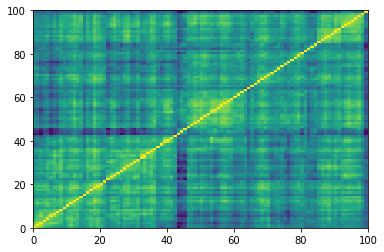

In [28]:
plt.pcolormesh(corr_matrices)